In [247]:
# Exercise 1: Try a Support Vector Machine Regressor
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing
import numpy as np

In [248]:
housing = fetch_california_housing()
X = housing.data[:5000]
y = housing.target[:5000]

svr_linear = SVR(kernel="linear", C=1.0)
svr_rbf = SVR(kernel="rbf", C=1.0, gamma=0.1)

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svr", svr_linear)
])

scores_linear = cross_val_score(pipeline, X, y, cv=3, scoring="neg_mean_squared_error")
print("Linear Kernel MSE:", -scores_linear.mean())

Linear Kernel MSE: 2.2765090833201875


In [249]:
pipeline.set_params(svr=svr_rbf)
scores_rbf = cross_val_score(pipeline, X, y, cv=3, scoring="neg_mean_squared_error")
print("RBF Kernel MSE:", -scores_rbf.mean())

RBF Kernel MSE: 1.31501874456884


In [250]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

param_distributions = {
    "svr__C": uniform(0.1, 10),
    "svr__gamma": uniform(0.001, 0.1)}

random_search = RandomizedSearchCV(pipeline, param_distributions, n_iter=10, cv=3, scoring="neg_mean_squared_error", random_state=42)
random_search.fit(X, y)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('svr', SVR(gamma=0.1))]),
                   param_distributions={'svr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f08e94cc490>,
                                        'svr__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f08e8dead90>},
                   random_state=42, scoring='neg_mean_squared_error')

In [251]:
random_search.best_params_

{'svr__C': np.float64(1.6601864044243653),
 'svr__gamma': np.float64(0.016599452033620267)}

In [252]:
print("Best SVR MSE:", -random_search.best_score_)

Best SVR MSE: 1.1689706433895695


In [253]:
# Exercise 3: Add SelectFromModel to pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

feature_selector = SelectFromModel(RandomForestRegressor(n_estimators=100))

In [254]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("feature_selection", feature_selector),
    ("svr", SVR())
])

pipeline.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestRegressor())),
                ('svr', SVR())])

In [255]:
print("Selected features shape:", pipeline.named_steps["feature_selection"].transform(X).shape)

Selected features shape: (5000, 2)


In [256]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsRegressor

class KNNFeatureAdder(BaseEstimator, TransformerMixin):
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        self.knn = KNeighborsRegressor(n_neighbors=self.n_neighbors)
        self.knn.fit(X, y)
        return self

    def transform(self, X):
        return self.knn.predict(X).reshape(-1, 1)

In [257]:
latitude_longitude = X[:, [0, 1]]
knn_feature = KNNFeatureAdder().fit(latitude_longitude, y).transform(latitude_longitude)
knn_feature

array([[4.095202],
       [3.962   ],
       [3.954402],
       ...,
       [0.8842  ],
       [1.4632  ],
       [1.4902  ]])

In [258]:
# Exercise 5: Use GridSearchCV to test prep options
from sklearn.model_selection import GridSearchCV

param_grid = {
    "svr__C": [0.1, 1, 10],
    "svr__gamma": [0.01, 0.1]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring="neg_mean_squared_error")
grid_search.fit(X, y)
print("GridSearch best parameters:", grid_search.best_params_)
print("GridSearch best MSE:", -grid_search.best_score_)

GridSearch best parameters: {'svr__C': 0.1, 'svr__gamma': 0.01}
GridSearch best MSE: 1.17952175442104


In [259]:
# Exercise 6: StandardScalerClone
import numpy as np

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.mean_ = np.mean(X, axis=0)
        self.scale_ = np.std(X, axis=0)
        self.n_features_in_ = X.shape[1]
        if hasattr(X, 'columns'):
            self.feature_names_in_ = np.array(X.columns)
        return self

    def transform(self, X):
        return (X - self.mean_) / self.scale_

    def inverse_transform(self, X):
        return X * self.scale_ + self.mean_

    def get_feature_names_out(self, input_features=None):
        if input_features is not None:
            if hasattr(self, 'feature_names_in_'):
                assert len(input_features) == self.n_features_in_
                assert all(input_features == self.feature_names_in_)
            return np.array(input_features)
        if hasattr(self, 'feature_names_in_'):
            return self.feature_names_in_
        return np.array([f"x{i}" for i in range(self.n_features_in_)])

# Classification

In [260]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784',  as_frame=False)

X,y=mnist["data"],mnist["target"]

In [261]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [262]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [263]:
X.shape

(70000, 784)

In [264]:
y.shape

(70000,)

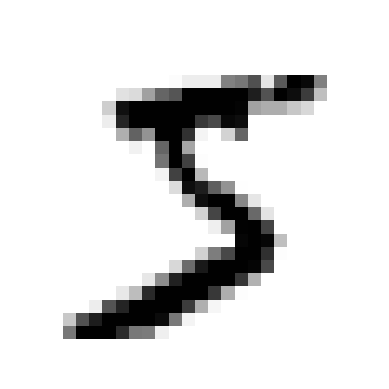

In [265]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [266]:
y[0]

'5'

In [267]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

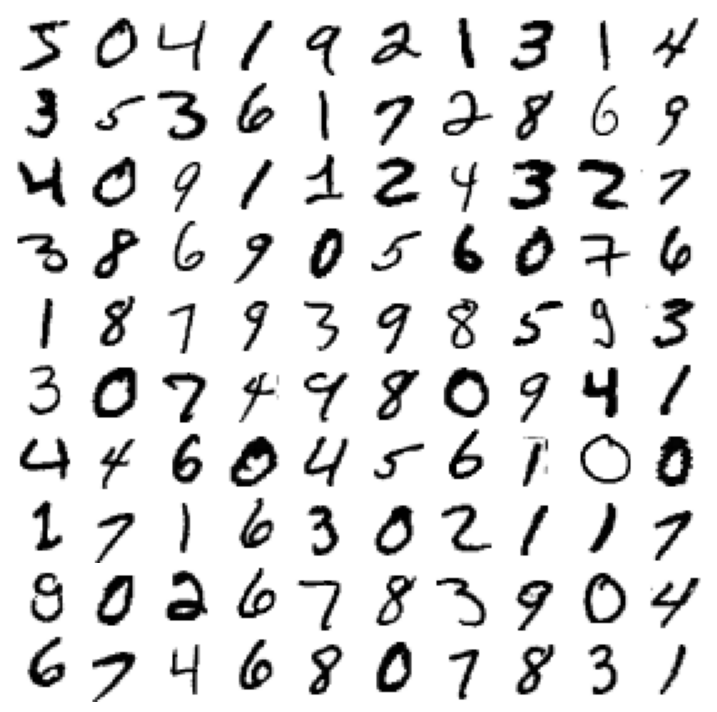

In [268]:
plt.figure(figsize=(9, 9))

for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [269]:
y_train_5 = (y_train == '5')  # Yalnız 5-lər üçün True, qalanları üçün False
y_test_5 = (y_test == '5')

In [270]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [271]:
some_digit = X[0]
sgd_clf.predict([some_digit])

array([ True])

In [272]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [273]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [274]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [275]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

In [276]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [277]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

In [278]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

#  Precision and Recall

In [279]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [280]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [281]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

Precision/Recall Trade-off

In [282]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [283]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [284]:
y_some_digit_pred

array([ True])

In [285]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [286]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [287]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

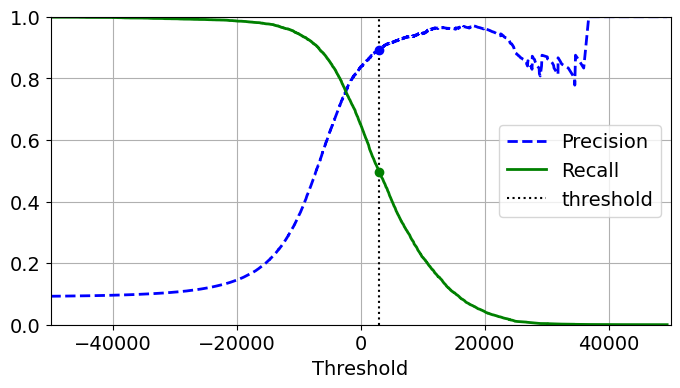

In [288]:
plt.figure(figsize=(8, 4))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

idx = (thresholds >= threshold).argmax()
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

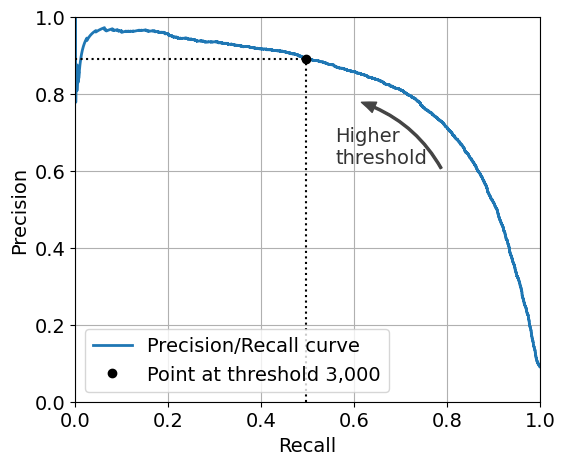

In [289]:
import matplotlib.patches as patches
plt.figure(figsize=(6, 5))
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
plt.show()

In [290]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

np.float64(3370.0194991439557)

In [291]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [292]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [293]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

The ROC Curve

In [294]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

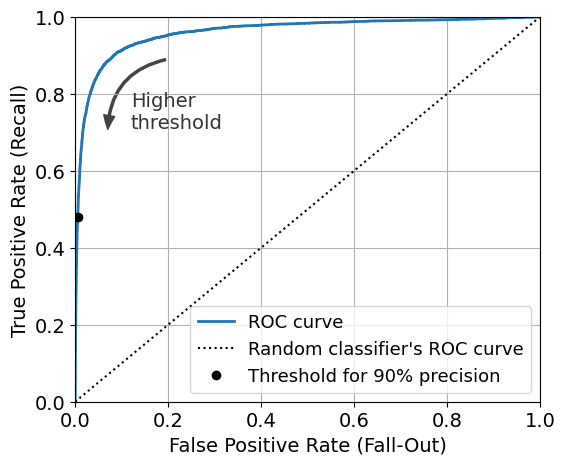

In [295]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
plt.show()

In [296]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

In [297]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [298]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [299]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [300]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

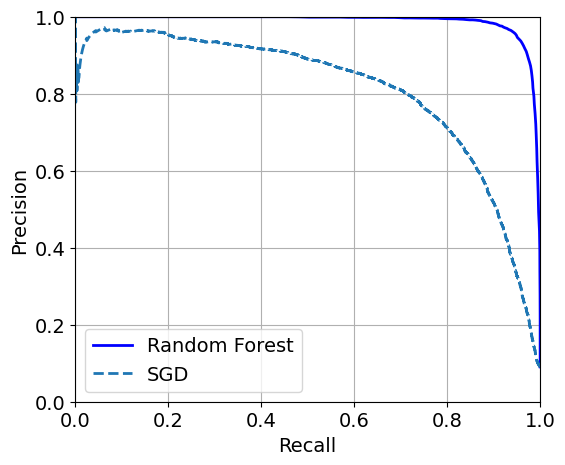

In [301]:
plt.figure(figsize=(6, 5))

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
plt.show()

In [302]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # positive proba ≥ 50%
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [303]:
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983436731328145)

In [304]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [305]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

 Multiclass Classification

In [306]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

In [307]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [308]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [309]:
class_id = some_digit_scores.argmax()
class_id

np.int64(5)

In [310]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [311]:
svm_clf.classes_[class_id]

'5'

In [312]:
svm_clf.decision_function_shape = "ovo"
some_digit_scores_ovo = svm_clf.decision_function([some_digit])
some_digit_scores_ovo.round(2)

array([[ 0.11, -0.21, -0.97,  0.51, -1.01,  0.19,  0.09, -0.31, -0.04,
        -0.45, -1.28,  0.25, -1.01, -0.13, -0.32, -0.9 , -0.36, -0.93,
         0.79, -1.  ,  0.45,  0.24, -0.24,  0.25,  1.54, -0.77,  1.11,
         1.13,  1.04,  1.2 , -1.42, -0.53, -0.45, -0.99, -0.95,  1.21,
         1.  ,  1.  ,  1.08, -0.02, -0.67, -0.14, -0.3 , -0.13,  0.25]])

In [313]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [314]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [315]:
len(ovr_clf.estimators_)

10

In [316]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [317]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [318]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [319]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

Error Analysis

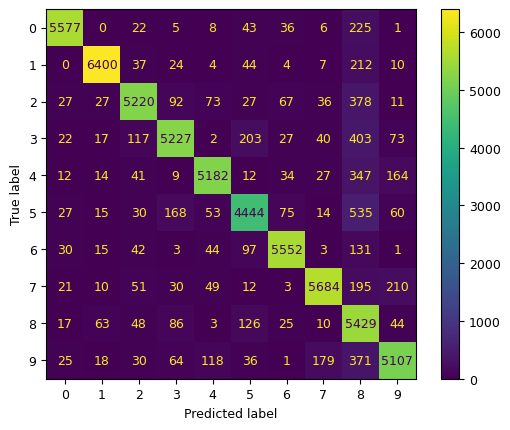

In [320]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
plt.rc('font', size=9)

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

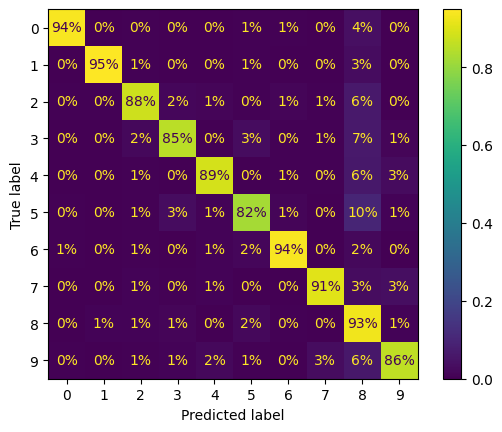

In [321]:
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize="true", values_format=".0%")
plt.show()

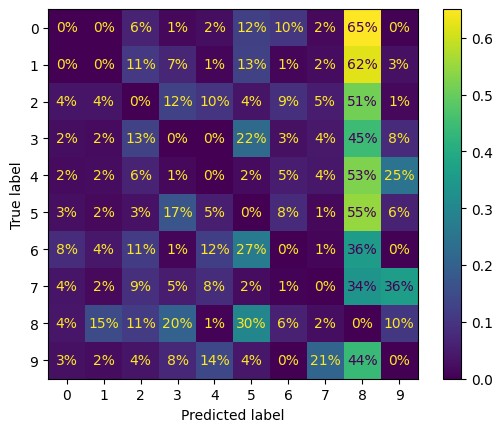

In [322]:
sample_weight = (y_train_pred != y_train)
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
plt.show()

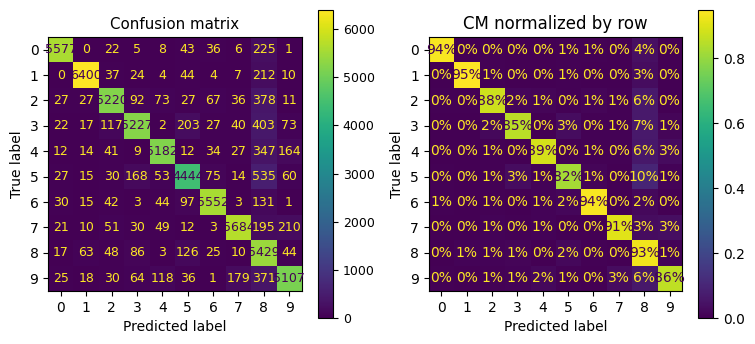

In [323]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=9)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0])
axs[0].set_title("Confusion matrix")

plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1],
                                        normalize="true", values_format=".0%")
axs[1].set_title("CM normalized by row")
plt.show()

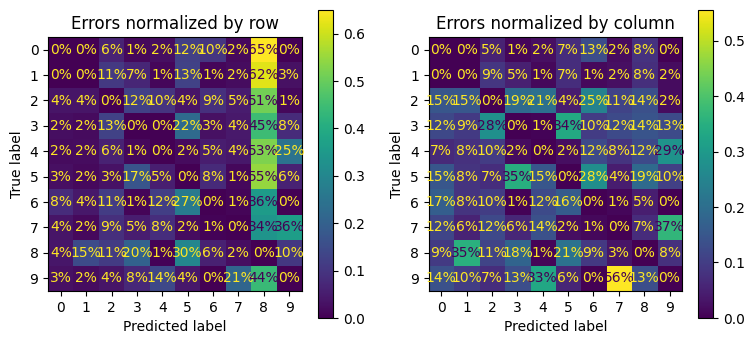

In [324]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0],
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
axs[0].set_title("Errors normalized by row")
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1],
                                        sample_weight=sample_weight,
                                        normalize="pred", values_format=".0%")
axs[1].set_title("Errors normalized by column")
plt.show()
plt.rc('font', size=14)

In [325]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

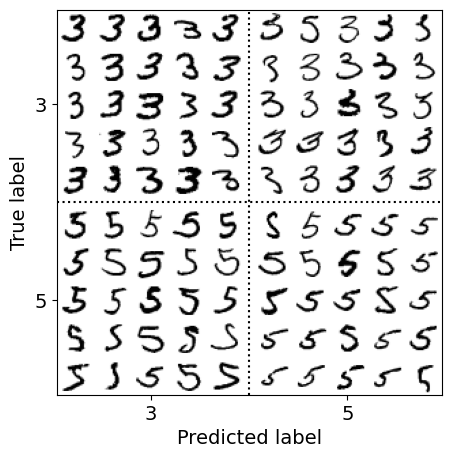

In [326]:
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

Multilabel Classification

In [327]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [328]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [329]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

In [330]:
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

0.9778357403921755

In [331]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [332]:
chain_clf.predict([some_digit])

array([[0., 1.]])

MultiOutputClassifier

In [332]:
np.random.seed(42)
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [332]:
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])
plt.show()

In [332]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()